In [108]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import poppy

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

from magpyx.fdpr2 import console, tools

wavelength = 633e-9

In [2]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [3]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

# Do the normalization

In [21]:
scoobi.move_psf(-20, 0, client0)

In [22]:
reload(scoobi)
xc, yc = (4360, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [24]:
reload(scoobi)
tbi.set_zwo_exp_time(0.00001, client0)

Set the ZWO exposure time to 3.20e-05s


In [25]:
reload(scoobi)
tbi.set_zwo_emgain(120, client0)

Set the ZWO gain setting to 120.0


In [38]:
reload(scoobi)
tbi.set_fib_atten(12, client)

Set the fiber attenuation to 12.0


In [34]:
scoobi.move_psf(-2, 0, client0)

In [77]:
scoobi.move_psf(0, 5, client0)

65532


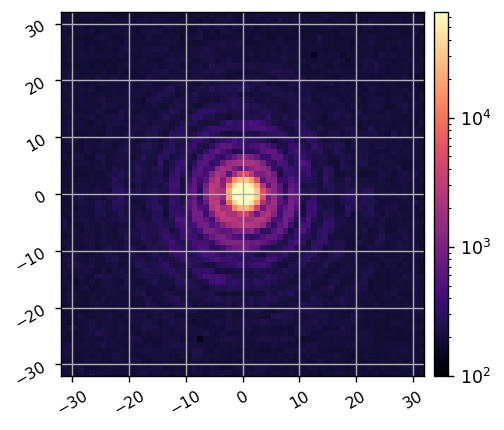

In [39]:
tbi.return_ni = False
psf = tbi.snap()

print(xp.max(psf))
imshow1(psf, lognorm=True, vmin=1e2, pxscl=1, grid=True, npix=64)

In [40]:
config_params = tools.Configuration('fdpr2_kilo_dmdiv')
fitdict, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:536: RuntimeWarning: divide by zero encountered in log
  amp_lnrms = np.std(np.log(amp_norm)[amp_mask])#rms(np.log(amp_norm), pupil)
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:124: RuntimeWarning: divide by zero encountered in log
  log_amp = np.log(amp)
INFO:fdpr2:Estimated phase RMS: 0.199 (rad)
INFO:fdpr2:Estimated amplitude RMS: 8.4 (%)
INFO:fdpr2:Estimated Strehl: 0.95 (0.96 phase-only and 0.99 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


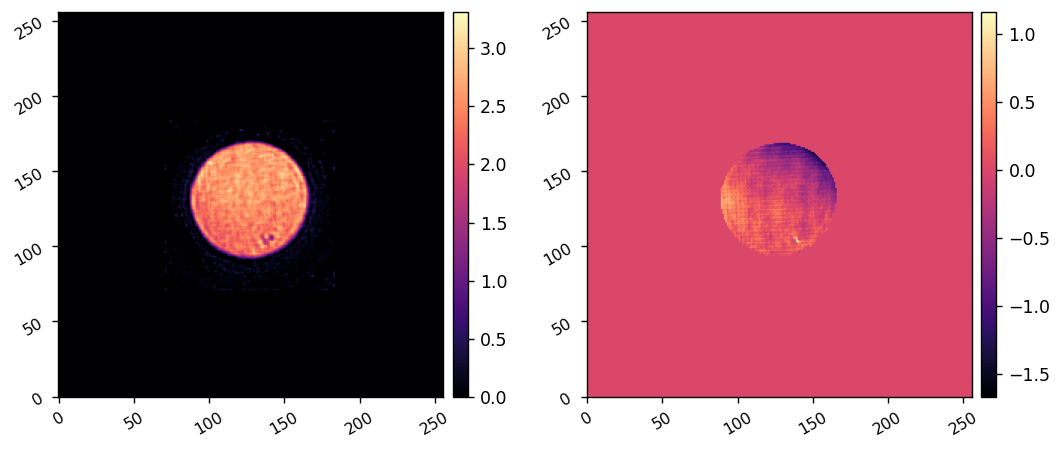

In [41]:
imshow2(fitdict['amp_est'], fitdict['phase_est'])

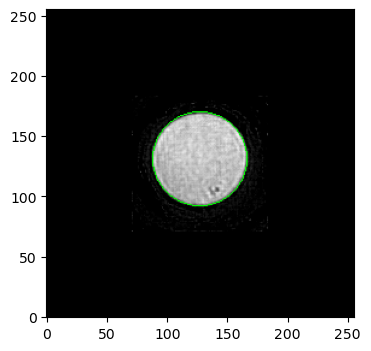

In [91]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Load picture and detect edges
# image = img_as_ubyte(data.coins()[160:230, 70:270])
image = img_as_ubyte(fitdict['amp_est']/np.max(fitdict['amp_est']))
# image = img_as_ubyte(np.abs(fitdict['phase_est'])/np.max(np.abs(fitdict['phase_est'])))
edges = canny(image, sigma=3, low_threshold=10, high_threshold=100)

# Detect two radii
hough_radii = np.arange(30, 60, 9)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

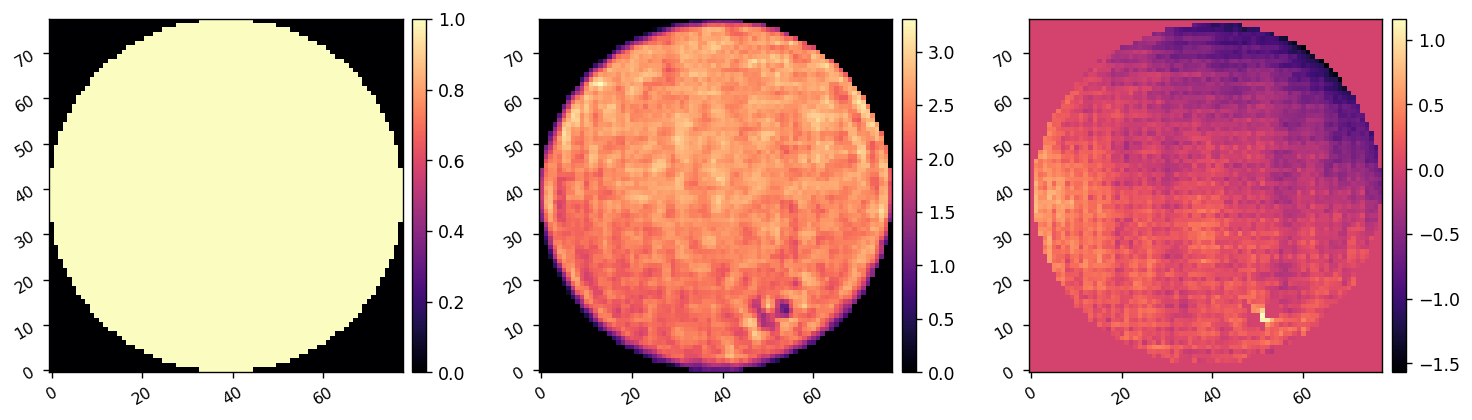

In [116]:
amp_est = fitdict['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est = fitdict['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
Nfit = amp_est.shape[0]
y,x = (np.indices((Nfit, Nfit)) - Nfit/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<radii[0]

amp_est *= fit_mask
phs_est *= fit_mask
imshow3(fit_mask, amp_est, phs_est)



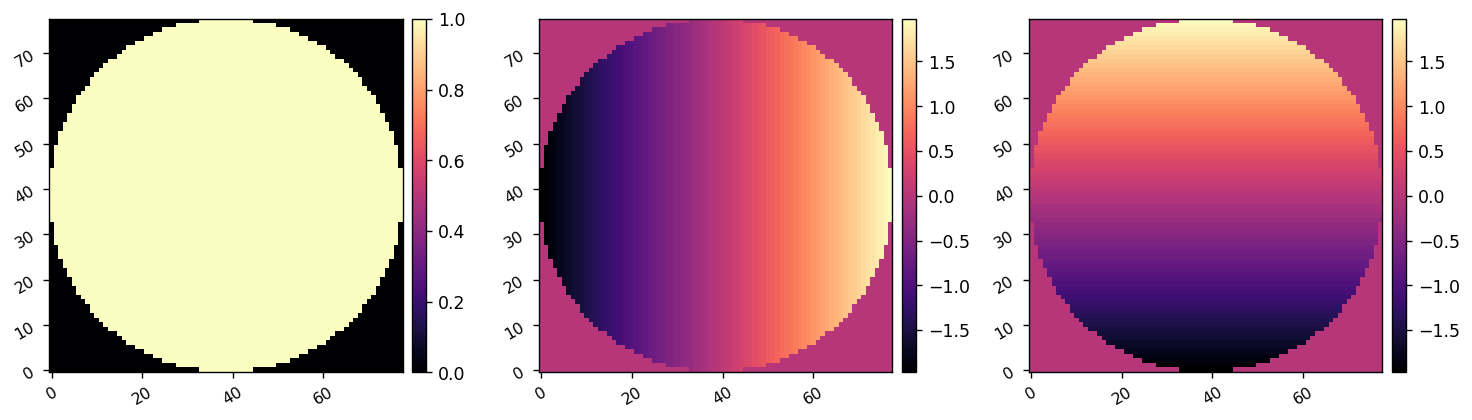

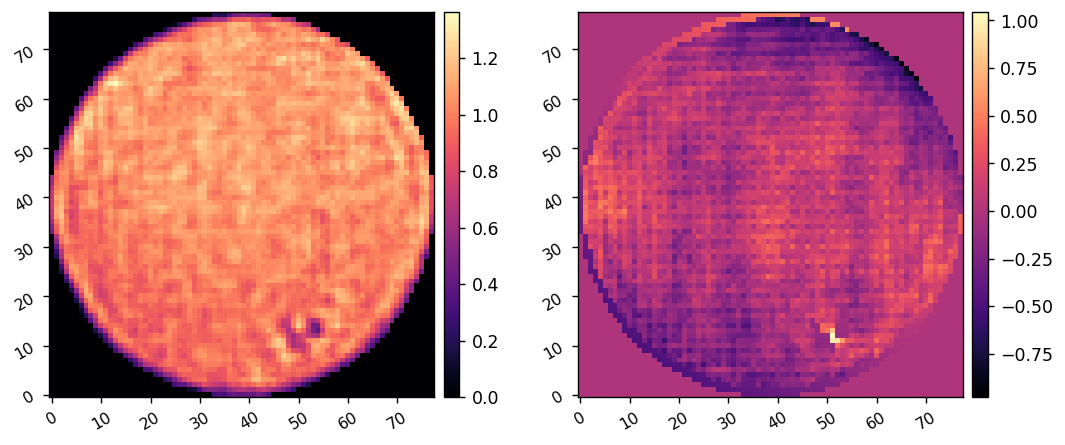

In [117]:
ptt_modes = poppy.zernike.arbitrary_basis(fit_mask, nterms=3, outside=0)
imshow3(ptt_modes[0], ptt_modes[1], ptt_modes[2])

ptt_coeff = scoobpsf.utils.lstsq(ptt_modes,xp.array(phs_est))
ptt = ensure_np_array(ptt_modes.reshape(3,-1).T.dot(ptt_coeff).reshape(Nfit,Nfit))
phs_est_minus_ptt = phs_est - ptt

amp_est /= np.mean(amp_est[fit_mask])

imshow2(amp_est/np.mean(amp_est[fit_mask]), phs_est_minus_ptt)




In [139]:
npix = 1000
Nlyot = np.round(npix * 8.6/9.1) +2
print(Nlyot)

947.0


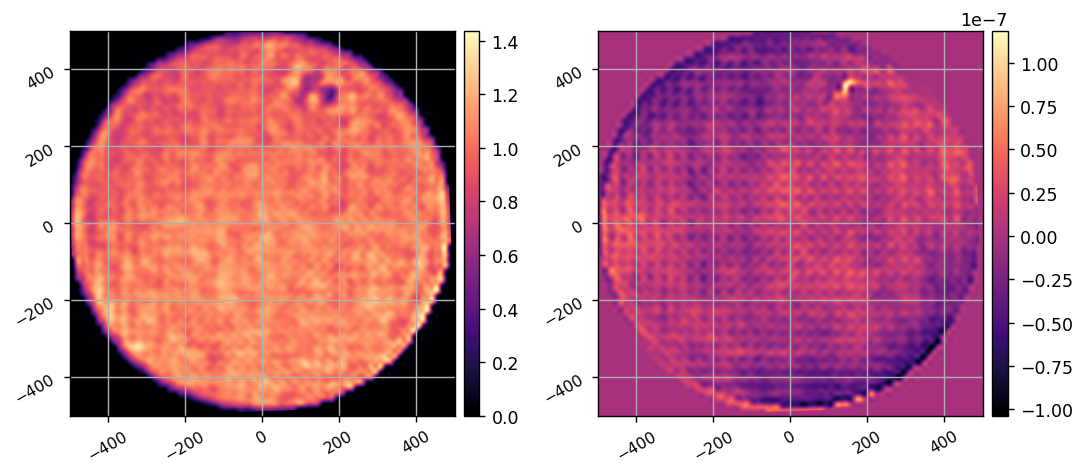

In [142]:
iamp_est = scoobpsf.utils.interp_arr(xp.array(amp_est), 1/Nfit, 1/npix, order=5)
iphs_est = scoobpsf.utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/npix, order=5)

# iamp_est = scoobpsf.utils.interp_arr(xp.array(amp_est), 1/Nfit, 1/Nlyot, order=5)
# iphs_est = scoobpsf.utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/Nlyot, order=5)

iamp_est = scoobpsf.utils.rotate_arr(iamp_est, 2, reshape=False, order=5)
iphs_est = scoobpsf.utils.rotate_arr(iphs_est, 2, reshape=False, order=5)

iamp_est = xp.flipud(iamp_est)
iphs_est = xp.flipud(iphs_est)

iamp_est[iamp_est<0] = 0
iopd_est = iphs_est * wavelength / (2*np.pi)

if iamp_est.shape[0] != npix:
    iamp_est = scoobpsf.utils.pad_or_crop(iamp_est, npix)
    iopd_est = scoobpsf.utils.pad_or_crop(iopd_est, npix)

imshow2(iamp_est, iopd_est, pxscl=1, grid=True)


In [143]:
iamp_est.shape

(1000, 1000)

In [144]:
scoobpsf.utils.save_fits('data/pr_est_amp.fits', iamp_est)
scoobpsf.utils.save_fits('data/pr_est_opd.fits', iopd_est)

Saved data to:  data/pr_est_amp.fits
Saved data to:  data/pr_est_opd.fits


ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624
Traceback (most recent call last):
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/transports.py", line 154, in _reconnection_monitor
    self._socket.connect((self.host, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624
Traceback (most recent call last):
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/transports.py", line 154, in _reconnection_monitor
    self._socket.connect((self.host, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624
Traceback (most recent call last):
  File "